In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.svm import SVC, NuSVC, SVR
from scipy import stats
from constants import *
from auxiliary_functions import *
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from collections import namedtuple
from sklearn.decomposition import PCA
from os import cpu_count
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import iqr, kurtosis, skew
from create_nqi_features_with_hand_direction_partition import create_nqi_features_from_raw_data_with_sides_partitions
from method1_feature_extraction import *
from plots import *
import random

### Configuration Constants

In [3]:
# if set to False, data will be loaded from previously processed saved files.
# Else, it will be created from the raw data inside DATA_FOLDER/RawData.zip.
PROCESS_DATA_FILES = True

# if set to False, features will be loaded from previously saved files. Else they will be created from scratch.
CALCULATE_FEATURES = True

# Load Data

In [4]:
if PROCESS_DATA_FILES:
    from zipfile import ZipFile  
    with ZipFile(os.path.join(DATA_FOLDER, RAW_DATA_ZIP_FILENAME)) as myzip:
        myzip.extractall(DATA_FOLDER)

## Load full users and taps datasets from Kaggle

In [5]:
from kaggle_data_loader import *

if PROCESS_DATA_FILES:
    # Create dataframe from files, perform basic cleaning
    kaggle_users = create_merged_users_details_file()
    kaggle_taps = create_merged_taps_dataframe()
    kaggle_taps = clean_bad_values(kaggle_taps)
    kaggle_taps = clean_incompatible_user_ids(kaggle_taps, kaggle_users)

Loading taps files: 100/622


Loading taps files: 200/622


Loading taps files: 300/622


Loading taps files: 400/622


Loading taps files: 500/622


Loading taps files: 600/622


Filtered out 386 rows with bad values in column 'HoldTime'


Filtered out 167 rows with bad values in column 'LatencyTime'


Filtered out 196 rows with bad values in column 'FlightTime'


Filtered out 0 rows with bad values in column 'Direction'


Filtered out 0 rows with bad values in column 'Hand'


there are 50 unique user IDs in the Tappy data with no entry in the Users file


Filtered out 301925 rows with bad values in column 'ID'


Filter outliers:

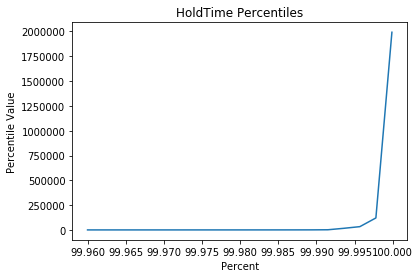

After the percentile 99.993 we see significantly higher values, which are definitely outliers.


Filtered out 631 rows with outliers in column 'HoldTime'


In [6]:
if PROCESS_DATA_FILES:
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    def plot_percentiles_of_column(df, col, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[col], x) for x in X]
        plt.plot(X, Y)
        plt.title(col + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    # Filter out outliers of HoldTime:
    plot_percentiles_of_column(kaggle_taps, 'HoldTime', 99.96, 99.9999, 20)
    print("After the percentile 99.993 we see significantly higher values, which are definitely outliers.")
    kaggle_taps = filter_column_by_quantile(kaggle_taps, 'HoldTime', 99.993)

In the above plot, we can for the 'HoldTime' column the values after which the observations are clearly outliers, therefore we filter them out. In the other columns there are no such clear cut-off values.

Divide keystrokes to time-intervals of 90 seconds:

In [7]:
if PROCESS_DATA_FILES:

    # Add parsed date and time column + calculate cumulative time
    kaggle_taps = add_cumulative_timestamps_column(kaggle_taps)
    
    # Group to bin indexes by the cumulative timestamps
    def build_bins(df, bin_size_seconds):
        df["PressTimeCumulative"] = df["PressTimeCumulative"] / 1000
        max_press = (int(max((df["PressTimeCumulative"])) / bin_size_seconds) + 1) * bin_size_seconds + 1
        user_bins = [i for i in range(0, max_press, bin_size_seconds)]
        df["binIndex"] = pd.cut((df["PressTimeCumulative"]), user_bins)
        return df
    
    
    kaggle_taps = build_bins(kaggle_taps, 90)
    
    # Keep only necessary columns and save to file
    kaggle_taps = kaggle_taps[TAPS_FINAL_COLUMNS + ['binIndex']]    
    kaggle_taps.to_csv(constants.KAGGLE_TAPS_INPUT, index=False)

Starting parsing of timestamps into cumulative time...


Filtered out 0 rows with bad values in column 'PressTimeCumulative'
Parsing ended, took 512.98 seconds


In [8]:
kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT)
kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT)

print("Kaggle taps final dataframe:\n")
print(kaggle_taps.head())
print("\nKaggle users dataframe:\n")
print(kaggle_users.head())

Kaggle taps final dataframe:

   LatencyTime Direction  FlightTime          ID  HoldTime Hand binIndex
0        234.4        LL       156.3  0EA27ICBLF     101.6    L  (0, 90]
1        437.5        LL       359.4  0EA27ICBLF      85.9    L  (0, 90]
2        210.9        LL       125.0  0EA27ICBLF      78.1    L  (0, 90]
3        359.4        LL       281.3  0EA27ICBLF      62.5    L  (0, 90]
4        187.5        LS        93.8  0EA27ICBLF     125.0    S  (0, 90]

Kaggle users dataframe:

   BirthYear     DA DiagnosisYear  Gender          ID  Impact  Levadopa  \
0     1952.0   True          2000  Female  0EA27ICBLF  Severe      True   
1     1959.0  False        ------  Female  0QAZFRHQHW  ------     False   
2     1946.0  False        ------  Female  0WTDIGPSBZ  ------     False   
3     1944.0  False        ------    Male  1HOEBIGASW  ------     False   
4     1953.0  False          2017    Male  1WMVCCU4RH  Medium     False   

    MAOB  Other  Parkinsons Sided  Tremors       UPDRS 

### Summary plots on Kaggle data

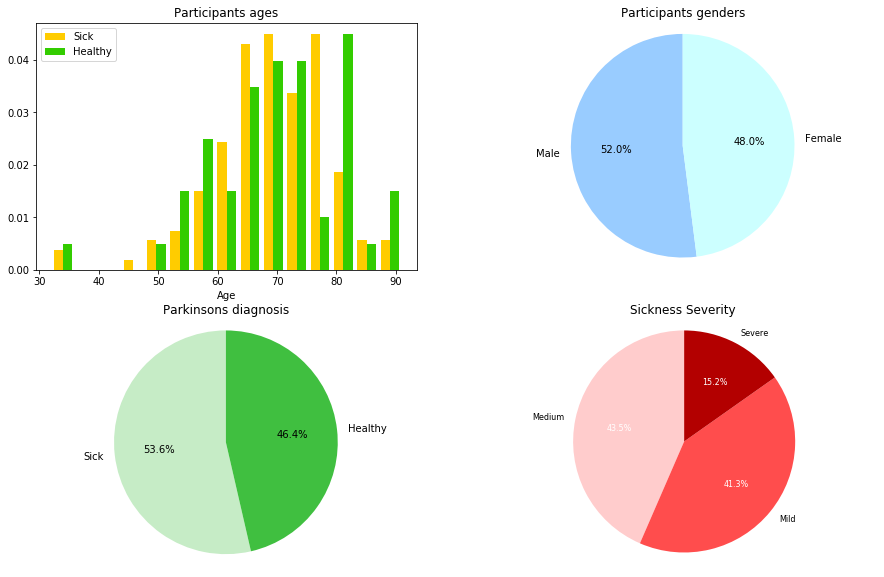

In [9]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

ages = add_age_column(kaggle_users)
mild_users = keep_only_mild_users(kaggle_users)

# general statistics of the users
fig = plt.figure(figsize=(15, 10))
ages_plot(fig, ages)
genders_plot(fig, mild_users)
diagnosis_plot(fig, mild_users)
sickness_level_plot(fig, ages)

warnings.resetwarnings()

#### In-depth analysis of the values in 'HoldTime'

An important finding that we had during the analysis of the Kaggle data, is that there is a significant number of specific 'HoldTime' values that occur hundreds of thousands of times in the data, sometimes even in a series of sequential keystrokes, in a pattern that is totally unlikely.

10 most common values in 'HoldTime' and their count:

HoldTime
82.0     235253
117.2    260154
70.3     264541
125.0    304250
101.6    323205
85.9     339476
62.5     352945
109.4    387298
93.8     490810
78.1     645667
Name: HoldTime, dtype: int64


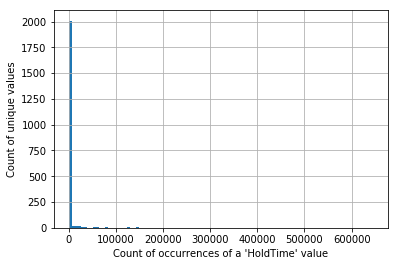

In [10]:
holdTimeCounters = kaggle_taps.groupby(['HoldTime']).HoldTime.count().sort_values()
print("10 most common values in 'HoldTime' and their count:\n")
print(holdTimeCounters.tail(10))
hist = holdTimeCounters.hist(bins=100).set(xlabel="Count of occurrences of a 'HoldTime' value", ylabel="Count of unique values")

We can see that most of the values appear less than 200 times, while there are some extreme values that appear hundreds of thousand of time.

As an example, let's focus on the extreme value '78.1'. If it were a valid normal value, we would expect to see that the density of it's appearance count should be similar to that of values around it. Let's plot the histogram around the value '78.1': 

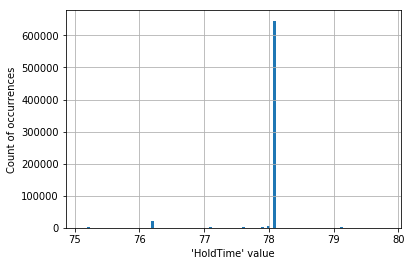

In [11]:
hist = kaggle_taps[(kaggle_taps.HoldTime < 80) & (kaggle_taps.HoldTime > 75)].HoldTime \
    .hist(bins=100).set(xlabel="'HoldTime' value", ylabel="Count of occurrences")

We can see that the value is '78.1' is extremely common (>600,000 occurrences) while other close values are rare.
We therefore conclude that the Kaggle data has built-in corrupted entries which are hard to distinguish from the correct ones. Trying to filter out such extremely common values leads to losing the vast majority of tha data. We therefore decided to continue working with the original data but keeping in mind the understanding that the signal could be corrupted.

## Load full users and taps datasets from MIT dataset

In [12]:
from mit_data_loader import *
    
if PROCESS_DATA_FILES:
    mit_users = pd.read_csv(USERS, delimiter=',', header=0, error_bad_lines=False,
                            low_memory=False, usecols=["pID", "gt", "updrs108", "file_1", "file_2"])
    
    mit_taps = create_merged_taps_dataframe()
    mit_taps = clean_errors_and_bad_values(mit_taps)

    print("\nMIT taps initial dataframe:\n")
    print(mit_taps.head())

Filtered out 1 rows with bad values in column 'HoldTime'
Filtered out 3504 rows with bad values in column 'LatencyTime'
Filtered out 12987 rows with bad values in column 'FlightTime'


Filtered out 0 rows with bad values in column 'pressTime'
Filtered out 10664 rows with bad values in column 'Hand'


Filtered out 5817 rows with bad values in column 'Direction'

MIT taps initial dataframe:

   ID Hand Direction HoldTime  LatencyTime FlightTime pressTime
1  68    R        LR   0.1194  1.40111e+09     1.7662    1.8314
2  68    L        RL   0.1337       0.5904      0.471    2.4218
3  68    L        LL   0.1847       0.4731     0.3394    2.8949
4  68    L        LL   0.1499       0.3464     0.1617    3.2413
5  68    R        LR   0.2137       0.7203     0.5704    3.9616


Divide keystrokes to time-intervals of 90 seconds:

In [13]:
if PROCESS_DATA_FILES:

    # Group to bin indexes by pressTime and add as a new column
    bin_size_seconds = 90
    max_press = (int(max(mit_taps["pressTime"]) / bin_size_seconds) + 1) * bin_size_seconds + 1
    user_bins = [i for i in range(0, max_press, bin_size_seconds)]
    mit_taps["binIndex"] = pd.cut(mit_taps["pressTime"], user_bins)

Filter outliers:

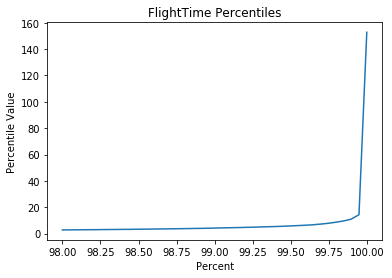

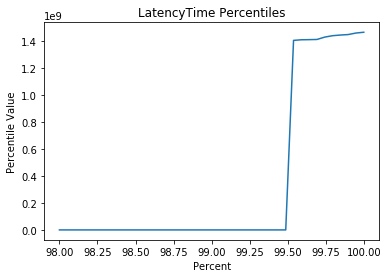

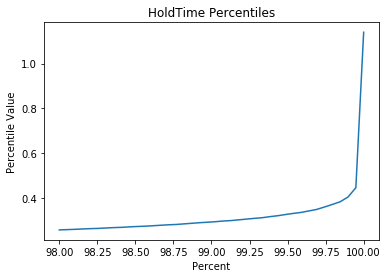

Filtered out 15 rows with outliers in column 'HoldTime'
Filtered out 867 rows with outliers in column 'LatencyTime'


Filtered out 72 rows with outliers in column 'FlightTime'


In [14]:
if PROCESS_DATA_FILES:
    
    def plot_percentile(df, column, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[column], x) for x in X]
        plt.plot(X, Y)
        plt.title(column + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    for col in list(set(FLOAT_COLUMNS) - {"pressTime"}):
        plot_percentile(mit_taps, col, 98, 99.9999, 40)
    
    # Filter according to the results in the plots
    mit_taps = filter_column_by_quantile(mit_taps, "HoldTime", 99.99)
    mit_taps = filter_column_by_quantile(mit_taps, "LatencyTime", 99.4)
    mit_taps = filter_column_by_quantile(mit_taps, "FlightTime", 99.95)

In the above plots, we can see for each column the values after which the observations are clearly outliers, therefore we filter them out.

Save final dataframe:

In [15]:
if PROCESS_DATA_FILES:

    # Save to file - Taps file
    mit_taps[["HoldTime", "LatencyTime", "FlightTime"]] = \
        1000 * mit_taps[["HoldTime", "LatencyTime", "FlightTime"]]  # to milliseconds
    mit_taps.to_csv(MIT_TAPS_INPUT, index=False)
    
    # Save to file - Users file
    mit_users.rename(columns={'pID': 'ID', 'gt': 'Parkinsons', 'updrs108': 'UPDRS'}, inplace=True)
    mit_users = mit_users[['ID', 'Parkinsons', 'UPDRS']]
    
    mit_users.to_csv(MIT_USERS_INPUT, index=False)

In [16]:
mit_taps = pd.read_csv(MIT_TAPS_INPUT)
mit_users = pd.read_csv(MIT_USERS_INPUT)

print("MIT users dataframe:\n")
print(mit_users.head())
print("\nMIT taps final dataframe:\n")
print(mit_taps.head())

MIT users dataframe:

   ID  Parkinsons  UPDRS
0  11        True  14.25
1  60       False   2.00
2  67        True  25.25
3  68       False   6.00
4  70        True  26.25

MIT taps final dataframe:

   ID Hand Direction  HoldTime  LatencyTime  FlightTime  pressTime binIndex
0  68    L        RL     133.7        590.4       471.0     2.4218  (0, 90]
1  68    L        LL     184.7        473.1       339.4     2.8949  (0, 90]
2  68    L        LL     149.9        346.4       161.7     3.2413  (0, 90]
3  68    R        LR     213.7        720.3       570.4     3.9616  (0, 90]
4  68    R        RR     164.3       2505.7      2291.9     6.4673  (0, 90]


Summary plots on MIT data:

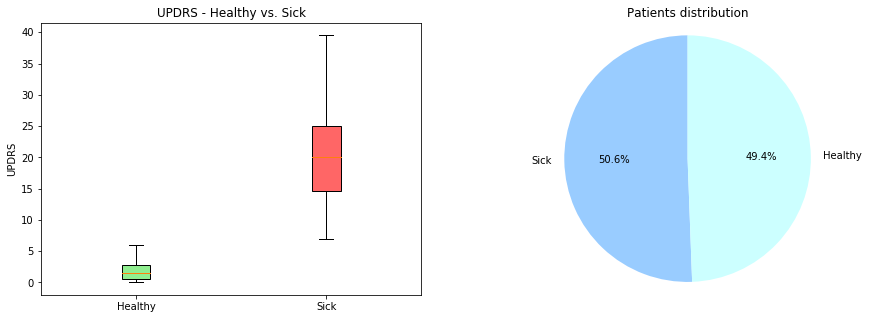

In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(15, 5))
mit_updrs_distribution(fig, mit_users)
mit_diagnosis(fig, mit_users)

warnings.resetwarnings()

# Feature Creation

## 1. Creating features from the Kaggle data set, according to the first approach:

For every patient, calculate summary statistics for all of their data, partitioned into Left/Right, and LR/RL/LL/RR transitions: 


In [18]:
if CALCULATE_FEATURES:
    method1_features = create_summary_statistics(kaggle_taps,
                                                 columns_to_aggregate=["FlightTime", "HoldTime", "LatencyTime"],
                                                 aggregation_functions=[np.mean, np.std, stats.kurtosis, stats.skew,
                                                            stats.entropy, percnt10, percnt20, percnt40, percnt60, percnt70,
                                                            percnt80, percnt90])
    # Add a feature of the mean-diff between Left and Right HoldTimes, and Between LR and RL LatencyTimes:
    method1_features["mean_diff_L_R_HoldTime"] = method1_features.R_HoldTime_mean - method1_features.L_HoldTime_mean
    method1_features["mean_diff_LR_RL_LatencyTime"] = method1_features.RL_LatencyTime_mean - method1_features.LR_LatencyTime_mean
    method1_features["mean_diff_LL_RR_LatencyTime"] = method1_features.LL_LatencyTime_mean - method1_features.RR_LatencyTime_mean
    
    # Join with the Users data:
    method1_features = method1_features.merge(kaggle_users, on="ID", how="left")
    # Dump to csv:
    method1_features.to_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
else:
    method1_features = pd.read_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
    
print("Summary statistics on the Kaggle data:\n\n",method1_features.head())

Summary statistics on the Kaggle data:

            ID  L_FlightTime_mean  L_FlightTime_std  L_FlightTime_kurtosis  \
0  0EA27ICBLF         239.655394        107.822976              -1.263192   
1  0QAZFRHQHW         319.277429        162.896291              -0.659685   
2  1HOEBIGASW         386.722581        175.209404              -0.927794   
3  1XNJCXS3EY         226.013786         85.352172              -0.493719   
4  2JTCBKUP8T         265.411441        160.215877              -0.093353   

   L_FlightTime_skew  L_FlightTime_entropy  L_FlightTime_percnt10  \
0          -0.032858             11.148338                   93.8   
1           0.361020              6.322468                  117.2   
2          -0.326568              3.319654                  132.8   
3          -0.125464              6.045913                  113.3   
4           0.540118              8.959632                   54.7   

   L_FlightTime_percnt20  L_FlightTime_percnt40  L_FlightTime_percnt60  \
0      

Filter the data so that we only keep patients with plenty of tapping events, and only patients with mild Parkinsons:

In [19]:
method1_features = method1_features[method1_features.total_count >= TAPS_THRESHOLD]  # take only users with more than THRESHOLD keystrokes
method1_features = method1_features[method1_features.Levadopa.astype(str) == 'False']
method1_features = method1_features[(method1_features.Parkinsons.astype(str) == 'False') | ( (method1_features.Parkinsons.astype(str) == 'True') & (method1_features.Impact == "Mild"))]

### Summary plots of Kaggle data features

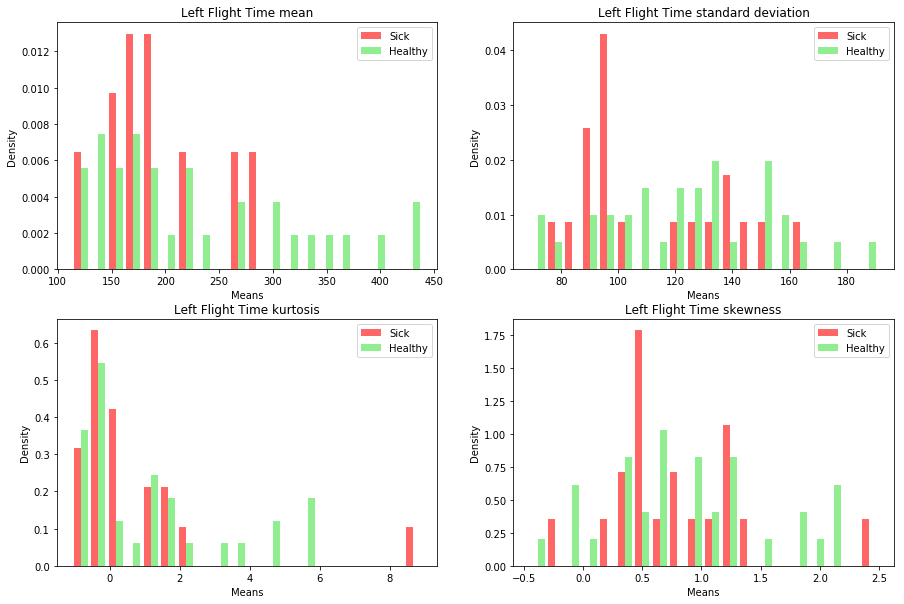

In [20]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

sick = method1_features.loc[(method1_features['Parkinsons'] == True)]
healthy = method1_features.loc[(method1_features['Parkinsons'] == False)]

fig = plt.figure(figsize=(15, 10))
lFlight_mean(fig, sick, healthy)
lFlight_std(fig, sick, healthy)
lFlight_kurtosis(fig, sick, healthy)
lFlight_skew(fig, sick, healthy)

Following are the plots describing the differences in means of different sides (Left, Right) HoldTime and side transitions (Left-to-Right, Right-to-Left, etc) LatencyTime:

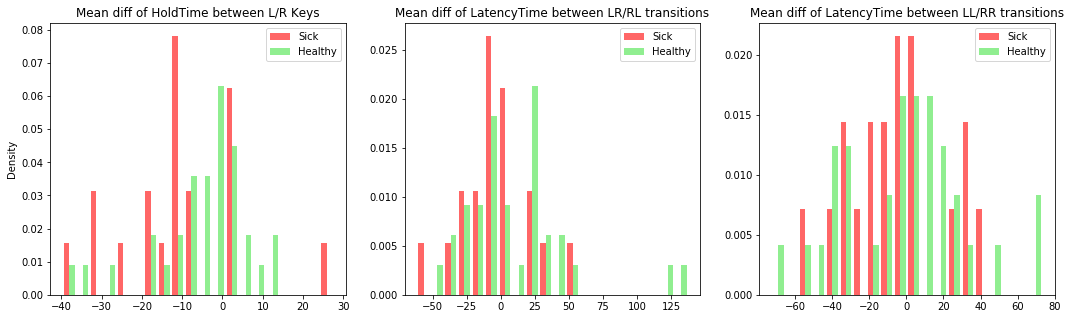

In [21]:
fig = plt.figure(figsize=(18, 5))

LR_Hold_Time(fig, healthy, sick)
LR_RL_Latency_Time(fig, healthy, sick)
LL_RR_Latency_Time(fig, healthy, sick)

warnings.resetwarnings()

# Modeling Phase 1: Attempting to reproduce the results from the Kaggle challenge article

In [22]:
# The summary statistics used in the original article:
ARTICLE_EXPLANATORY_VARIABLES =['L_HoldTime_mean', 'L_HoldTime_std', 'L_HoldTime_kurtosis', 'L_HoldTime_skew',
 'R_HoldTime_mean', 'R_HoldTime_std', 'R_HoldTime_kurtosis', 'R_HoldTime_skew', 'LL_LatencyTime_mean', 'LL_LatencyTime_std',
 'LL_LatencyTime_kurtosis', 'LL_LatencyTime_skew', 'LR_LatencyTime_mean', 'LR_LatencyTime_std', 'LR_LatencyTime_kurtosis',
 'LR_LatencyTime_skew', 'RL_LatencyTime_mean', 'RL_LatencyTime_std', 'RL_LatencyTime_kurtosis', 'RL_LatencyTime_skew',
 'RR_LatencyTime_mean', 'RR_LatencyTime_std', 'RR_LatencyTime_kurtosis', 'RR_LatencyTime_skew', 'mean_diff_LR_RL_LatencyTime',
 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']

### First attempt: applying several models to the raw data with the variables used in the article, without further processing:


In [23]:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),
               SVC(kernel='rbf', probability=True),
               ]
for final_classifier in classifiers:
    accuracy = evaluate_classifier_cv(final_classifier, X, y, cross_validation_folds=5)
    print(str(final_classifier).split("(")[0] + ":")
    print("\t"+accuracy.train)
    print("\t" + accuracy.test)

LogisticRegression:
	Train accuracy:0.7885
	Test accuracy (5-fold cross validation):0.4636
RandomForestClassifier:
	Train accuracy:0.9615
	Test accuracy (5-fold cross validation):0.5218


AdaBoostClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6127
KNeighborsClassifier:
	Train accuracy:0.6538
	Test accuracy (5-fold cross validation):0.5345


GradientBoostingClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.52
SVC:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6291


we can see that all models are highly overfitted, and do not perform well.

### Second attempt: normalize the data and apply PCA dimensionality reduction

In [24]:
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)

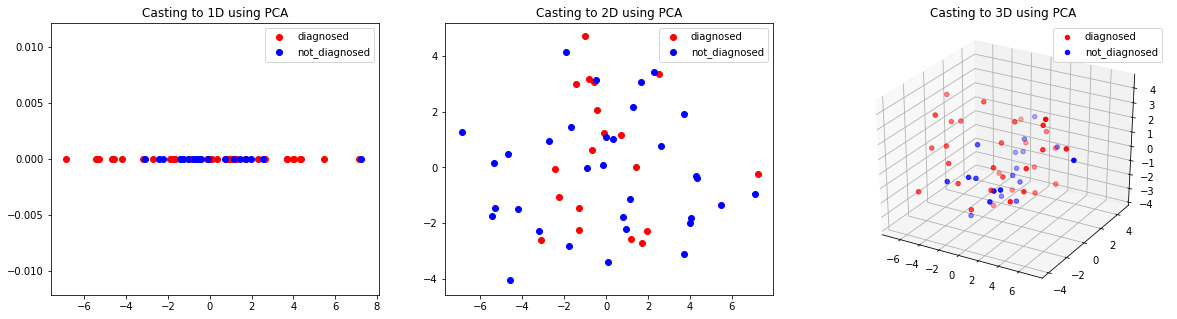

In [25]:
# Visualizing the data in 3d, 2d and 1d after PCA:

pca = PCA(n_components=1)
reduced_X = pca.fit_transform(normalized_X)
_1d_res = get_labeled_data_1d(reduced_X, y)

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(normalized_X)
_2d_res = get_labeled_data_2d(reduced_X, y)

pca = PCA(n_components=3)
reduced_X = pca.fit_transform(normalized_X)
_3d_res = get_labeled_data_3d(reduced_X, y)

plot_dimensionality_reduction(_1d_res, _2d_res, _3d_res)

From the above plots, it is evident that the data is not well seperated in low dimensions. We now try all possible dimensionality reductions, and for every number of dimensions we reduce to, we apply several classification models and keep the test score of the best one:

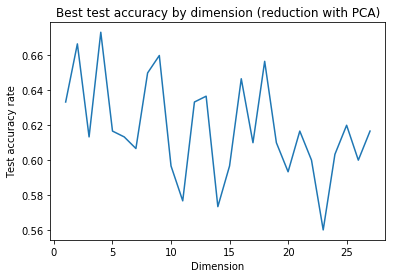

In [26]:
original_dim = len(normalized_X[0])
tested_dimensions = []
accuracies = []
for dim in [i for i in range(1, original_dim+1)]:
    if dim != original_dim:
        pca = PCA(n_components=dim)
        reduced_X = pca.fit_transform(normalized_X, y.values)
    else:
        reduced_X = normalized_X
    best_accuracy = namedtuple("best_accuracy", "clf_name test_accuracy train_accuracy")
    best_accuracy.test_accuracy = -1  #init
    for clf in classifiers:
        accuracy = evaluate_classifier_cv(clf, reduced_X, y, cross_validation_folds=10)
        if accuracy.test_score > best_accuracy.test_accuracy:
            best_accuracy.test_accuracy = accuracy.test_score
            best_accuracy.clf_name = str(clf).split("(")[0]
    tested_dimensions.append(dim)
    accuracies.append(best_accuracy.test_accuracy)
plt.title("Best test accuracy by dimension (reduction with PCA)")
plt.xlabel("Dimension")
plt.ylabel("Test accuracy rate")
p = plt.plot(tested_dimensions, accuracies)


We can see that PCA dimensionality reduction does not improve performance.

We now apply LDA dimensionality reduction and scaling to the data, and randomly split to test and train sets. Results here have high variance due to the small size of the dataset, so we repeat the process 100 times and average the results:

In [27]:
# LDA produces a "Variables are collinear" warning here. This is true, 
# as the Pearson Correlation factor of some of the features is very close to one. As we now attempt to reproduce the results of the article,
# we will ignore this error.
res = pd.DataFrame()
for i in range(100):
    warnings.filterwarnings("ignore", category=UserWarning)
    train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                                   train_percentage=0.7)
    warnings.resetwarnings()
    
    # Fit several models, and find the best one by AUC measure:
    best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
    res = res.append([{'model': type(best_clf).__name__, 'score':best_auc}])
mean_values = res.groupby("model")["score"].mean()
print("Best AUC and model:\n\n", mean_values[mean_values == mean_values.max()])

Best AUC and model:

 model
LogisticRegression    0.537653
Name: score, dtype: float64


It is evident that neither technique of dimensionaliy reduction improves performance. 
We now explore adding additional predictors, specifically calculating percentiles of the HoldTime and LatencyTime, trying to better describe the distribution of these measures for each patient. Results here have high variance due to the small size of the dataset, so we repeat the process 100 times and average the results:

In [28]:
PERCENTILES = [c for c in method1_features.columns.values if "perc" in c and "FlightTime" not in c]
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES + PERCENTILES]
y = method1_features["Parkinsons"]

# LDA produces a "Variables are collinear" warning here. This is true, 
# as the Pearson Correlation factor of some of the features are very close to one. As we now attempt to reproduce the results of the article,
# we will ignore this error.

res = pd.DataFrame()
for i in range(100):
    warnings.filterwarnings("ignore", category=UserWarning)
    train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                                   train_percentage=0.7)
    warnings.resetwarnings()
    
    # Fit several models, and find the best one by AUC measure:
    best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
    res = res.append([{'model': type(best_clf).__name__, 'score':best_auc}])
mean_values = res.groupby("model")["score"].mean()
print("Best AUC and model:\n\n", mean_values[mean_values == mean_values.max()])

Best AUC and model:

 model
GradientBoostingClassifier    0.681818
Name: score, dtype: float64


We now continue to follow the method descdribed in the article, by partitioning the data into two groups, Hold variables and Latency variables (depending on the orignal column they were created by). 
We then assign a Parkinson's probability using each group seperately, and output a final probability as a weighted average of these two probabilities.

In [29]:
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
import warnings

ALL_VARIABLES = ARTICLE_EXPLANATORY_VARIABLES
HOLD_VARIABLES = [v for v in ALL_VARIABLES if "HoldTime" in v]
LATENCY_VARIABLES = [v for v in ALL_VARIABLES if "LatencyTime" in v]

voting_ensemble = VotingClassifier(estimators=[
                                    ('1', RandomForestClassifier()),
                                    ('2', SVC(probability=True)),
                                    ('3', MLPClassifier()),
                                    ('4', LogisticRegression()),
                                    ('5', NuSVC(probability=True)),
                                    ('6', KNeighborsClassifier()),
                                    ('7', DecisionTreeClassifier()),
                                    ('8', QuadraticDiscriminantAnalysis())
                                  ],
                        voting='soft')


def weighting_function(hold_probs, latency_probs):
    """
    These are the weights described in the article. We note that this weighting can yield probs > 1, and therefore is not optimal. 
    We've tried other weightings as well, with no significant improvement.
    """
    return (hold_probs + 0.5*(1-1.2) + 1.2*latency_probs)/2.0


groups_model = TwoGroupsWeightedModel(underlying_estimator_module_and_class="sklearn.pipeline Pipeline",
                            group1_var_names=HOLD_VARIABLES,
                            group2_var_names=LATENCY_VARIABLES,
                             weighting_function=weighting_function,              
                            classification_threshold=0.5,
                            steps=[("normalization", StandardScaler()),
                                   ("lda", LinearDiscriminantAnalysis()),
                                   ("clf", voting_ensemble)])

# calculate accuracy and AUC for the groups-model, using K-fold CV:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]

"""
Training the model on this data results in a "Collinear Variables" warnings. This is true, as some of the variables have very high Pearson-correlation.
In order to reporoduce the article findings we ignore these erros for now, and  filter warnings for the next few lines. 
"""
warnings.filterwarnings("ignore")
test_auc = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='roc_auc').test_score
test_accuracy = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='accuracy').test_score
warnings.resetwarnings()

print("Test AUC: {}\nTest Accuracy: {}".format(test_auc, test_accuracy))

Test AUC: 0.5905714285714285
Test Accuracy: 0.4618181818181818


<b>Conclusion:</b> in the above section we tried to reproduce and improve the classifying technique described in the article that inspired the Kaggle challenge.
We believe that the the results in the articles are not valid and non-reproducible, and we ellaborate further on this in the project document.

# Modeling Phase 2: A completely different approach, inspired by results published in Nature magazine by a team of MIT researchers

The main idea of this approach is to use a regression model to predict the UPDRS score of a patient, averaged over all of their keystrokes time windows, and subsequently apply a classification model to classify PD/non-PD based on that score.

We first construct the features for the UPDRS-regression:

In [30]:
from nqi_feature_creation_functions import *
MIN_PRESSES_PER_BUCKET_THRESHOLD = 1 # Filtering on a higher value did not prove usefull

# Create the UPDRS regression features for both the MIT and the Kaggle Datasets:

bin_identifier = ["ID", "binIndex"] # These two columns uniqely identify a user's time-window (90 secs of taps for specific user)
i = 1
if CALCULATE_FEATURES:
    for taps_input_file_path, nqi_features_output_filepath in \
            zip([MIT_TAPS_INPUT, KAGGLE_TAPS_INPUT], [MIT_NQI_FEATURES, KAGGLE_NQI_FEATURES]):
        print("Creating features for dataset #{}...".format(i))
        taps = pd.read_csv(taps_input_file_path)
        len_before = len(taps)
        taps = taps.groupby(bin_identifier).filter(lambda x: x['HoldTime'].count() > MIN_PRESSES_PER_BUCKET_THRESHOLD)
        print("\tRemoved {} rows from time-windows containing too few taps in file.".format(len_before - len(taps)))
        
        # Filter out time-windows where the IQR feature cannot be calculated (this happens in the Kaggle data set,
        # due to sparse time windows and HoltTime values that are very common. See project documentation for elaboration on this issue.)
        len_before = len(taps)
        taps = taps.groupby(bin_identifier).filter(lambda x: np.percentile(x.HoldTime, 25) != np.percentile(x.HoldTime, 75) )
        print("\tFiltered {} rows where the IQR feature cannot be calculated.".format(len_before - len(taps)))
        
        # Create summary statistics for HoldTime columns, per time-window (='binIndex'):
        grouped_taps = taps.groupby(bin_identifier)["HoldTime"].\
            agg([agg_outliers, agg_iqr, agg_histogram_bin0, agg_histogram_bin1, 
                 agg_histogram_bin2, agg_histogram_bin3, np.count_nonzero])
        # Rename columns for clarity:
        grouped_taps.rename(columns={c:'hold_'+c for c in grouped_taps.columns if c not in bin_identifier}, inplace=True)
        grouped_taps.rename(columns={'hold_count_nonzero':'count_nonzero'}, inplace=True)
        
        # Create summary statistics for FlightTime columns, per time-window (='binIndex'):
        flight_grouped = taps.groupby(bin_identifier)["FlightTime"].agg([np.mean, np.std]).reset_index()
        # Rename columns for clarity:
        flight_grouped.rename(columns={c: 'flight_' + c for c in flight_grouped.columns if c not in bin_identifier}, inplace=True)
        
        # Join all features together:
        nqi_calculator_input = grouped_taps.reset_index()
        nqi_calculator_input = nqi_calculator_input.merge(flight_grouped, on=bin_identifier)
        
        # Filter time-bins with insufficient taps:
        nqi_calculator_input = nqi_calculator_input[nqi_calculator_input.count_nonzero > MIN_PRESSES_PER_BUCKET_THRESHOLD]
        
        # Write result ot file:
        nqi_calculator_input.to_csv(nqi_features_output_filepath, index=False)
        print("\tDone.")
        i += 1

Creating features for dataset #1...


	Removed 6 rows from time-windows containing too few taps in file.


	Filtered 0 rows where the IQR feature cannot be calculated.


	Done.
Creating features for dataset #2...


	Removed 15042 rows from time-windows containing too few taps in file.


	Filtered 33650 rows where the IQR feature cannot be calculated.


	Done.


In [31]:
mit_nqi_features = pd.read_csv(MIT_NQI_FEATURES)
mit_users = pd.read_csv(MIT_USERS_INPUT)

mit_data = mit_nqi_features.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS = list_diff(mit_data.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

HOLD_FEATURES = [v for v in PREDICTION_COLUMNS if 'hold' in v]
FLIGHT_FEATURES = [v for v in PREDICTION_COLUMNS if 'flight' in v]

print("All regression features on the MIT dataset:\n\n", PREDICTION_COLUMNS)
print("\n\nMIT features sample:\n\n", mit_data.head())

# Split the unified MIT dataset to train and test according to ID's (IDs<=100 belong to train set, all others to test set):
train_mit_data = mit_data[mit_data.ID <= 100].copy()
test_mit_data = mit_data[mit_data.ID >= 1000].copy()

All regression features on the MIT dataset:

 ['hold_agg_outliers', 'hold_agg_iqr', 'hold_agg_histogram_bin0', 'hold_agg_histogram_bin1', 'hold_agg_histogram_bin2', 'hold_agg_histogram_bin3', 'flight_mean', 'flight_std']


MIT features sample:

    ID    binIndex  hold_agg_outliers  hold_agg_iqr  hold_agg_histogram_bin0  \
0  11     (0, 90]           0.018868      0.275847                 0.005585   
1  11  (180, 270]           0.018141      0.318952                 0.005170   
2  11  (270, 360]           0.027888      0.330284                 0.005689   
3  11  (360, 450]           0.028205      0.254762                 0.005682   
4  11  (450, 540]           0.011472      0.273350                 0.005629   

   hold_agg_histogram_bin1  hold_agg_histogram_bin2  hold_agg_histogram_bin3  \
0                 0.002340                 0.000075                 0.000000   
1                 0.002739                 0.000054                 0.000036   
2                 0.002279             

### Summary plots of MIT data features

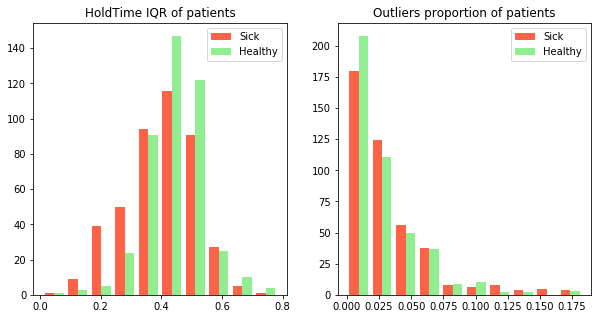

In [32]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(10,5))
iqr_histogram(fig, mit_data)
outliers_histogram(fig, mit_data)

warnings.resetwarnings()

### Construct a regression model to predict UPDRS score and then classify patients accordingly:

In [33]:
# We first define a function that performs the UPDRS-regression
# and subsequent classification using the regression's predictions:


def updrs_regression_and_pd_classification(train_data, test_data, regression_model, final_classifier, prediction_columns):
    """
    :param train_data, test_data: a DataFrame with NQI-features and regression target ('UPDRS').
    :param regression_model: the regression model that will be used for predicting the nqi score.
    :param final_classifier: the classification model that will be used for predicting Parkinson's/no-Parkinson's based on the predicted nqi score.
    :return: the test AUC of the final model, that uses the predicted-nqi in order to predict Parkinson's.
    """
    # Scale features and compress UPDRS to the [0,1] interval:
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))  # We use this to scale the UPDRS target to the [0,1] interval.
    
    train_X = train_data[prediction_columns]
    train_y = train_data["UPDRS"]
    
    train_X = pd.DataFrame(scaler.fit_transform(train_X))
    train_y = min_max_scaler.fit_transform(train_y.values.reshape(-1,1))
    
    test_X = test_data[prediction_columns]
    test_X = pd.DataFrame(scaler.transform(test_X))
    
    # Fit the regression model, and predict the test data:
    regression_model.fit(X=train_X, y=np.ravel(train_y))
    train_nqi_predictions = regression_model.predict(train_X)
    train_data["predicted_nqi"] = train_nqi_predictions
    
    # Calculate the average predicted-UPDRS (AKA 'NQI') per training patient:
    train_final_df = train_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # Predict nqi for every subject in the test-set (as mean of predicted UPDRS of all the subjects' time-windows):
    test_nqi_predictions = regression_model.predict(test_X)
    test_data["predicted_nqi"] = test_nqi_predictions
    test_final_df = test_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # Use the result of the nqi-regression, to predict Parkinsons and calculate test score:    
    final_classifier.fit(train_final_df["predicted_nqi"].values.reshape(-1, 1), train_final_df["Parkinsons"])
    predicted_test_probs = final_classifier.predict_proba(test_final_df["predicted_nqi"].values.reshape(-1, 1))[:, 1]
    test_set_auc = roc_auc_score(y_true=test_final_df["Parkinsons"], y_score=predicted_test_probs)
    
    # Store results in a results object:
    result = namedtuple('result', 'test_auc y_true y_predicted test_df')
    result.test_auc, result.y_true, result.y_predicted, result.test_df  = \
        test_set_auc, test_final_df["Parkinsons"], predicted_test_probs, test_final_df.copy()
    
    return result 

We now apply the UPDRS-regression procedure defined above. We use a bagging-ensemble of 200 support-vector regressors, and apply it to the HoldTime features (in accordance with the original research). We then use logistic regression as the final classifier (Our tests show that most classification models yield very similar results, so this choice is not critical). 

In [34]:
sv_regression_ensemble = BaggingRegressor(base_estimator=SVR(),
                                n_estimators=200,
                                bootstrap=True,
                                n_jobs=1)

updrs_regression_on_mit_data_with_sv_regression_hold_features_results = \
    updrs_regression_and_pd_classification(train_mit_data, test_mit_data,
                                         regression_model=sv_regression_ensemble,
                                         final_classifier=LogisticRegression(), 
                                         prediction_columns=HOLD_FEATURES)
test_auc = updrs_regression_on_mit_data_with_sv_regression_hold_features_results.test_auc
print("Test AUC using support-vector regression and the HoldTime features (original article features): {}".format(test_auc))

Test AUC using support-vector regression and the HoldTime features (original article features): 0.7138888888888889


We can see that the above method provides reasonable results. Our test-AUC are very close to the CI provided in the article (0.72-0.87). We now add statistical features based on the LatencyTime columns that we calculated. This was not performed in the original article:

In [35]:
sv_regression_ensemble = BaggingRegressor(base_estimator=SVR(),
                                n_estimators=200,
                                bootstrap=True,
                                n_jobs=1)

updrs_regression_on_mit_data_with_sv_regression_all_features_results = \
    updrs_regression_and_pd_classification(train_mit_data, test_mit_data,
                                           regression_model=sv_regression_ensemble,
                                           final_classifier=LogisticRegression(),
                                           prediction_columns=HOLD_FEATURES + FLIGHT_FEATURES)

test_auc = updrs_regression_on_mit_data_with_sv_regression_all_features_results.test_auc
print("Test AUC using support-vector regression and both HoldTime and FlightTime features (our added features): {}".format(test_auc))

Test AUC using support-vector regression and both HoldTime and FlightTime features (our added features): 0.7444444444444445


We can see that the above method works well, providing similar results to those described in the article (our result are within the CI of the AUC achieved in the Nature article). The features selected above were designed to incorporate the FlightTime as well, which we assumed should be useful for detection of Parkinson. We've tried many other statistics for both HoldTime and LatencyTime, with limited success, and we omit these tests for brevity.


Another point for improvement would be to use a more powerful regression model. We found the following to be more effective - we use a large forest of boosted regression trees instead of the support-vector regression ensemble:

In [36]:
gbt_regression_ensemble = GradientBoostingRegressor(n_estimators=1000)
updrs_regression_on_mit_data_with_gbt_regression_hold_features_results = updrs_regression_and_pd_classification(
                                                train_mit_data, test_mit_data,
                                                regression_model=gbt_regression_ensemble,
                                                final_classifier=LogisticRegression(), 
                                                prediction_columns=HOLD_FEATURES
                                                )
print("Test AUC using gb-tree regression with only the HoldTime features: {}".
      format(updrs_regression_on_mit_data_with_gbt_regression_hold_features_results.test_auc))

updrs_regression_on_mit_data_with_gbt_regression_all_features_results = updrs_regression_and_pd_classification(
                                                train_mit_data, test_mit_data,
                                                regression_model=gbt_regression_ensemble,
                                                final_classifier=LogisticRegression(), 
                                                prediction_columns=HOLD_FEATURES + FLIGHT_FEATURES
                                                )
print("Test AUC using gb-tree regression using HoldTime+FlightTime features: {}".
      format(updrs_regression_on_mit_data_with_gbt_regression_all_features_results.test_auc))

Test AUC using gb-tree regression with only the HoldTime features: 0.7833333333333333


Test AUC using gb-tree regression using HoldTime+FlightTime features: 0.8347222222222223


<b>Conclusion:</b> Using gradient-boosting regression yields better results, and improves over the previous models. Together with our additional LatencyTime features we see significant improvement.

We try to provide a visual way to see the improvement in the model, in addition to the higher AUC score. 
The plots below show the predicted NQI scores (mean UPDRS over time-windows per subject) for each target-class (PD/non-PD), in the first model and in the last improved model. On the right we see slightly better seperation between PD/non-PD patients in their predicted NQI.

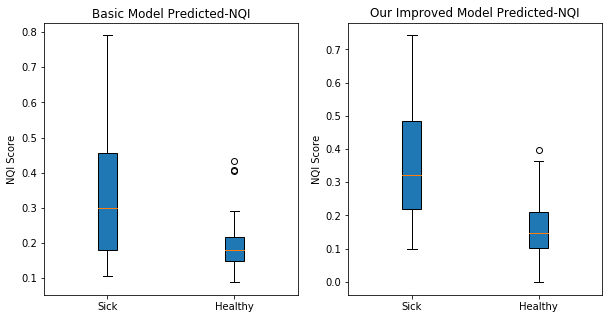

In [37]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

basic_model_test_result = updrs_regression_on_mit_data_with_sv_regression_hold_features_results.test_df
our_model_test_result = updrs_regression_on_mit_data_with_gbt_regression_all_features_results.test_df

fig = plt.figure(figsize=(10,5))
boxplot_nqi_score(fig, 1, basic_model_test_result, "Basic Model Predicted-NQI")
boxplot_nqi_score(fig, 2, our_model_test_result, "Our Improved Model Predicted-NQI")

warnings.resetwarnings()

The plots above suggest a visual way to see the improvement in the model, in addition to the higher AUC score. On the right we see better separation between PD/non-PD patients in their predicted NQI.

# Optimize regressor hyper-parameters:

In [38]:
train_X = train_mit_data[HOLD_FEATURES + FLIGHT_FEATURES]
train_y = train_mit_data["UPDRS"]

param_space = {
    'n_estimators': [100, 500, 1000],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [1, 2, 3, 5, 7, 8],
    'max_leaf_nodes': [None, 3, 5, 10, 50, 100]
}

grid_searcher = GridSearchCV(gbt_regression_ensemble, param_grid=param_space, n_jobs=-1, cv=3, verbose=2, scoring="r2")
grid_searcher.fit(X=train_X, y=np.ravel(train_y))
print("Best params:\n", grid_searcher.best_params_)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.4s


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.4s


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.9min


[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.9min


[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.2min


[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  8.5min


[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 10.3min finished


Best params:
 {'learning_rate': 0.01, 'loss': 'lad', 'max_depth': 2, 'max_leaf_nodes': 50, 'n_estimators': 100}


Calculate AUC with optimized parameters:

In [39]:
gbt_regression_ensemble.set_params(**grid_searcher.best_params_)

updrs_regression_on_mit_data_with_optimized_gbt_regression_results = \
                      updrs_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                             regression_model=gbt_regression_ensemble,
                                                             final_classifier=LogisticRegression(),
                                                             prediction_columns=HOLD_FEATURES + FLIGHT_FEATURES)
print("Test AUC using gb-tree regression after hyper-parameter optimization: {}".format(updrs_regression_on_mit_data_with_optimized_gbt_regression_results.test_auc))


Test AUC using gb-tree regression after hyper-parameter optimization: 0.7083333333333334


<b>Conclusion:</b> The optimization did not provide additional value, most likely due to the small size of the dataset.


We will now try to evaluate the relevance of the above method to home-environment data, by training the model on all of the MIT data, and testing it on the Kaggle data (which is home-environment data):

In [40]:
kaggle_nqi_features = pd.read_csv(KAGGLE_NQI_FEATURES)
kaggle_users_data = pd.read_csv(KAGGLE_USERS_INPUT)
kaggle_data = kaggle_nqi_features.merge(kaggle_users_data, on="ID").dropna().reset_index().drop(["index"], axis=1)

# Remove patients taking Levadopa or patients with non-mild Parkinson's:
kaggle_data = kaggle_data[kaggle_data.Levadopa==False]
kaggle_data = kaggle_data[kaggle_data.Parkinsons==False | ((kaggle_data.Parkinsons==True) & (kaggle_data.Impact == "Mild"))]


# Apply our model:
gbt_regression_ensemble = GradientBoostingRegressor(n_estimators=1000)
updrs_regression_on_kaggle_and_mit_data_with_gbt_regression_results = \
    updrs_regression_and_pd_classification(train_data=mit_data, test_data=kaggle_data,
                                           regression_model=gbt_regression_ensemble,
                                           final_classifier=LogisticRegression(),
                                           prediction_columns=HOLD_FEATURES + FLIGHT_FEATURES)
print("Test AUC on Kaggle data training on MIT data: {}".
      format(updrs_regression_on_kaggle_and_mit_data_with_gbt_regression_results.test_auc))

Test AUC on Kaggle data training on MIT data: 0.46793002915451887


We see above that the UPDRS-regression trained on the MIT data does not generalize well to the Kaggle data. We propose two possible explanations for this: it could be that the MIT data is fundamentally different, being collected in the lab and not at home. Another possible explanation is that the Kaggle data is corrupt (this could explain the inability to reproduce the first article).

Our next step is to apply the main idea from the first article, i.e splitting the keystrokes according to the side of the keyboard in which they occur, to the MIT data using all the features constructed above for UPDRS regression. We hope that those features will introduce measures of functional asymmetry to the model which may prove useful:

In [41]:
# Preparing the MIT data with measures of asymmetry:
nqi_features_with_side_partitions_data_path = create_nqi_features_from_raw_data_with_sides_partitions(MIT_TAPS_INPUT, MIT_NQI_FEATURES_SIDES_PARTITIONS)

mit_nqi_features_with_sides_partition = pd.read_csv(nqi_features_with_side_partitions_data_path)
mit_users = pd.read_csv(MIT_USERS_INPUT)

print("NQI features with keyboard side partitions:\n")
print(sorted(mit_nqi_features_with_sides_partition.columns))

mit_data_with_sides_partition = mit_nqi_features_with_sides_partition.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS_SIDE_PARTITION = list_diff(mit_data_with_sides_partition.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

# Split the unified MIT dataset to train and test according to ID's:
train_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID <= 100].copy()
test_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID >= 1000].copy()

NQI features with keyboard side partitions:

['ID', 'LL_flight_mean', 'LL_flight_std', 'LR_flight_mean', 'LR_flight_std', 'L_hold_agg_histogram_bin0', 'L_hold_agg_histogram_bin1', 'L_hold_agg_histogram_bin2', 'L_hold_agg_histogram_bin3', 'L_hold_agg_iqr', 'L_hold_agg_outliers', 'RL_flight_mean', 'RL_flight_std', 'RR_flight_mean', 'RR_flight_std', 'R_hold_agg_histogram_bin0', 'R_hold_agg_histogram_bin1', 'R_hold_agg_histogram_bin2', 'R_hold_agg_histogram_bin3', 'R_hold_agg_iqr', 'R_hold_agg_outliers', 'binIndex']


In [42]:
updrs_regression_on_mit_data_with_assymetry_features = \
    updrs_regression_and_pd_classification(train_data=train_mit_data_with_sides_partitions,
                                           test_data=test_mit_data_with_sides_partitions,
                                           regression_model=gbt_regression_ensemble,
                                           final_classifier=LogisticRegression(), 
                                           prediction_columns=PREDICTION_COLUMNS_SIDE_PARTITION)
print("Test AUC on MIT with assymetry measurement features (keyboard side partitions) : {}".
      format(updrs_regression_on_mit_data_with_assymetry_features.test_auc))

Test AUC on MIT with assymetry measurement features (keyboard side partitions) : 0.7722222222222223


<b>Conclusion:</b> our attempt to apply measuring asymmetry to the process of predicting a patient's UPDRS score did not improve the model over what we have previously achieved. This could be a result of the small size of our datatset, which suffers from high dimensionality when we introduce asymmetry features. Our attempts at dimensionality reduction on this dataset did not prove useful.

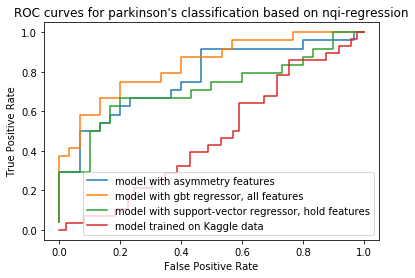

In [43]:
# Plot ROC curves for all of the above variations on the model:
plot_multiple_roc_curves([('model with asymmetry features', updrs_regression_on_mit_data_with_assymetry_features.y_true,
                           updrs_regression_on_mit_data_with_assymetry_features.y_predicted),                          
                          ('model with gbt regressor, all features', updrs_regression_on_mit_data_with_gbt_regression_all_features_results.y_true,
                           updrs_regression_on_mit_data_with_gbt_regression_all_features_results.y_predicted),                          
                          ('model with support-vector regressor, hold features', updrs_regression_on_mit_data_with_sv_regression_hold_features_results.y_true,
                           updrs_regression_on_mit_data_with_sv_regression_hold_features_results.y_predicted),                          
                          ('model trained on Kaggle data', updrs_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_true,
                           updrs_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_predicted),                          
                          ], 
                         title="ROC curves for parkinson's classification based on nqi-regression")

We now attempt to use the features that were constructed for the UPDRS-regression to directly classify a patient as PD/non-PD. This is desired because in the first dataset we do not have UPDRS scores so we cannot train the above model that performed well on the MIT dataset. 

In [44]:
kaggle_ids = kaggle_data.ID.unique()


NFOLDS = 10
cv_gen = KFold(NFOLDS, shuffle=True)

clf = GradientBoostingClassifier()
final_probabilities_over_folds = pd.DataFrame()

i = 1
for train_indices, test_indices in cv_gen.split(kaggle_ids):
    print("Fitting & testing fold #{}".format(i))
    train_ids = kaggle_ids[train_indices]
    test_ids = kaggle_ids[test_indices]
    train_data = kaggle_data[kaggle_data.ID.isin(train_ids)].copy()
    test_data = kaggle_data[kaggle_data.ID.isin(test_ids)].copy()
    clf.fit(train_data[PREDICTION_COLUMNS], train_data["Parkinsons"])
    test_data["predicted_pd_prob"] = clf.predict_proba(X=test_data[HOLD_FEATURES+FLIGHT_FEATURES])[:,1]
    
    # average probabilities over time-windows per-subject:
    final_probabilities_over_folds = pd.concat([final_probabilities_over_folds, test_data.groupby("ID")["predicted_pd_prob", "Parkinsons"].mean()])
    i += 1
print("\nsample of final predictions:\n", final_probabilities_over_folds.head())

Fitting & testing fold #1


Fitting & testing fold #2


Fitting & testing fold #3


Fitting & testing fold #4


Fitting & testing fold #5


Fitting & testing fold #6


Fitting & testing fold #7


Fitting & testing fold #8


Fitting & testing fold #9


Fitting & testing fold #10



sample of final predictions:
             predicted_pd_prob  Parkinsons
ID                                       
BENXJNDSC4           0.757250       False
EZF9NAHLOU           0.451967        True
FFNMFHHSZJ           0.757611       False
H08AW2YBAJ           0.592662       False
KRJVEQSLL5           0.341013       False


In [45]:
test_auc = roc_auc_score(y_true=final_probabilities_over_folds['Parkinsons'], 
                    y_score=final_probabilities_over_folds['predicted_pd_prob'])
print(test_auc)

0.5706997084548106


<b>Conclusion:</b> We see that this approach is not much better than random, although it could have potential given a home-environment data set of better quality and larger size.

# Final Conclusions

In this work, we investigated algorithmic prediction of early Parkinson’s Disease based on the patient’s keyboard tapping characteristics. We apply several different methods, following recent academic papers on the subject. 

In the first part, we tried to reproduce the results of the first article that initiated the Kaggle challenge. We reached a conclusion that the results given in this article are flawed, and elaborate more on this in the project document.
We successfully reproduced the results published in Nature magazine and introduced some significant improvements over it. We also leave leads for future research, by combining the use of asymmetry features in the UPDRS regression process. 
